<a href="https://colab.research.google.com/github/dinakeshvari/NLP_Exercise_ShokrzadCourse/blob/main/Project03_DS04_S03_TextClassification_RezaShokrzad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📝 Insult Detection with Word2Vec Embeddings

In this notebook, we will build a binary classification pipeline to detect insults in comments using Word2Vec embeddings. We'll apply:
- Logistic Regression
- Random Forest
- XGBoost

## 🚀 Goal
Detect whether a comment contains an insult (1) or not (0).


## 📦 Step 1: Install & Load Packages

In [1]:
!pip uninstall numpy -y

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [2]:
!pip install numpy==1.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 21.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
!pip install gensim==4.3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [4]:
!pip install pandas matplotlib seaborn scikit-learn xgboost kagglehub

In [ ]:
import os
os._exit(00)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

import kagglehub


## 📥 Step 2: Load and Inspect the Dataset


In [7]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to select and upload kaggle.json

Saving kaggle.json to kaggle.json


In [8]:
print(uploaded.keys())  # Should print: dict_keys(['kaggle.json'])

dict_keys(['kaggle.json'])


In [9]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/ 2>/dev/null || true  # Suppress error if file already moved
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
os.getcwd()

'/content'

In [4]:
# Download the dataset

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

In [6]:
import zipfile

zip_file_path = '/content/jigsaw-toxic-comment-classification-challenge.zip'
extraction_path = '/content/jiqsaw'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [7]:
# List files in the downloaded directory
print("Files in dataset directory:", os.listdir(extraction_path))

Files in dataset directory: ['train.csv.zip', 'test_labels.csv.zip', 'sample_submission.csv.zip', 'test.csv.zip']


## 🧹 Step 3: Preprocessing for Word2Vec



In [10]:
# We'll use Gensim's `simple_preprocess` to tokenize and clean the text.
with zipfile.ZipFile('/content/jiqsaw/train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(extraction_path)
with zipfile.ZipFile('/content/jiqsaw/test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(extraction_path)
train_df = pd.read_csv('/content/jiqsaw/train.csv')
test_df = pd.read_csv('/content/jiqsaw/test.csv')


In [11]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [20]:
test_df.head()

,id,comment_text,tokens,embedding
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[yo, bitch, ja, rule, is, more, succesful, the...","[0.51972, 0.44098133, 0.27608413, 0.05498261, ..."
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[from, rfc, the, title, is, fine, as, it, is, ...","[0.21443287, 0.47200665, 1.2411478, -0.7706495..."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[sources, zawe, ashton, on, lapland]","[0.16304664, 0.30083823, -0.20511337, 0.626018..."
3,00017563c3f7919a,":If you have a look back at the source, the in...","[if, you, have, look, back, at, the, source, t...","[0.22097917, 0.015886005, 0.3139646, -0.350763..."
4,00017695ad8997eb,I don't anonymously edit articles at all.,"[don, anonymously, edit, articles, at, all]","[0.11623069, 0.21159035, -1.6401275, 0.6773407..."


In [12]:
def preprocess_text(text):
    return [token for token in simple_preprocess(text)]

train_df['tokens'] = train_df['comment_text'].apply(preprocess_text)
test_df['tokens'] = test_df['comment_text'].apply(preprocess_text)

In [15]:
train_df['comment_text'] = train_df['comment_text'].fillna('')
test_df['comment_text'] = test_df['comment_text'].fillna('')

## 🧠 Step 4: Train Word2Vec Embedding

In [16]:
# We'll train Word2Vec embeddings on the entire corpus.
# Combine tokens from train_df and test_df
corpus = train_df['tokens'].tolist() + test_df['tokens'].tolist()
print("Total sentences in corpus:", len(corpus))

# Configure Word2Vec parameters
w2v_model = Word2Vec(
    sentences=corpus,
    vector_size=100,  # Embedding dimension
    window=5,        # Context window size
    min_count=5,     # Ignore words with frequency < 5
    workers=4,       # Number of CPU cores
    sg=0,            # 0 for CBOW, 1 for Skip-gram
    epochs=10        # Number of training epochs
)

# Save the model
w2v_model.save('jigsaw_w2v.model')
print("Word2Vec model trained and saved as 'jigsaw_w2v.model'")

# Example: Get embedding for a word
print("Embedding for 'example':", w2v_model.wv['example'][:5], "...")  # Show first 5 dimensions


Total sentences in corpus: 312735
Word2Vec model trained and saved as 'jigsaw_w2v.model'
Embedding for 'example': [-1.2237953   0.88389844  3.8121588  -0.94353265  0.3171597 ] ...


## 🧬 Step 5: Vectorize Comments using Word2Vec


In [ ]:
w2v_model = Word2Vec.load('jigsaw_w2v.model')
print("Word2Vec model loaded")

In [17]:
# Convert each comment to the average of its word vectors
def get_sentence_embedding(tokens, model, vector_size=100):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

# Apply to train_df and test_df
train_df['embedding'] = train_df['tokens'].apply(lambda x: get_sentence_embedding(x, w2v_model))
test_df['embedding'] = test_df['tokens'].apply(lambda x: get_sentence_embedding(x, w2v_model))

# Verify embeddings
print("Sample embedding from train_df (first 5 dimensions):")
print(train_df['embedding'].iloc[0][:5])
print("\nSample embedding from test_df (first 5 dimensions):")
print(test_df['embedding'].iloc[0][:5])


Sample embedding from train_df (first 5 dimensions):
[-0.16779172  0.03537638  0.09221752 -0.08253098 -0.10379791]

Sample embedding from test_df (first 5 dimensions):
[0.51972    0.44098133 0.27608413 0.05498261 0.01884476]


In [21]:
# Perform train-test split
X = np.stack(train_df['embedding'].values)  # Feature matrix (embeddings)
y = train_df['insult'].values              # Labels (insult)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

# Check label distribution
print("\nLabel distribution in y_train:", np.bincount(y_train) / len(y_train))
print("Label distribution in y_val:", np.bincount(y_val) / len(y_val))

X_train shape: (127656, 100)
X_val shape: (31915, 100)
y_train shape: (127656,)
y_val shape: (31915,)

Label distribution in y_train: [0.95063295 0.04936705]
Label distribution in y_val: [0.95065016 0.04934984]


In [22]:
X_test = np.stack(test_df['embedding'].values)


## 🤖 Step 6: Train Models

In [23]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"\n🔍 {name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



🔍 Logistic Regression Accuracy: 0.9146
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     30340
           1       0.35      0.89      0.51      1575

    accuracy                           0.91     31915
   macro avg       0.67      0.90      0.73     31915
weighted avg       0.96      0.91      0.93     31915



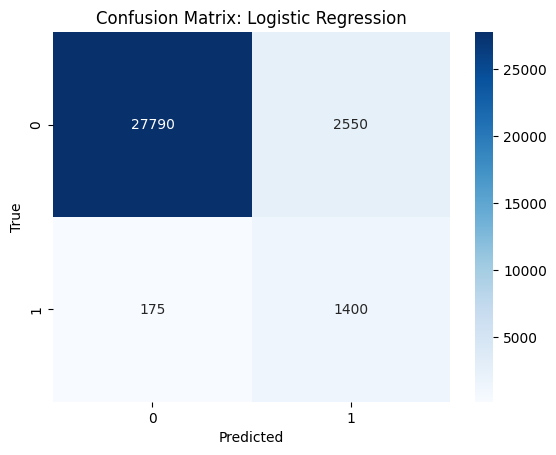


🔍 Random Forest Accuracy: 0.9642
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     30340
           1       0.81      0.36      0.50      1575

    accuracy                           0.96     31915
   macro avg       0.89      0.68      0.74     31915
weighted avg       0.96      0.96      0.96     31915



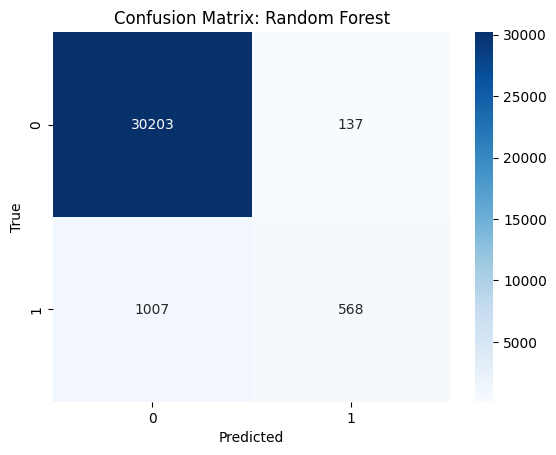


🔍 XGBoost Accuracy: 0.9558
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     30340
           1       0.54      0.73      0.62      1575

    accuracy                           0.96     31915
   macro avg       0.76      0.85      0.80     31915
weighted avg       0.96      0.96      0.96     31915



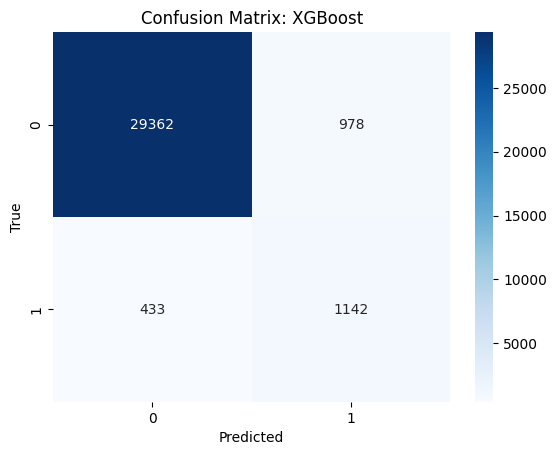

NameError: name 'files' is not defined

In [24]:

# Initialize and evaluate models
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
xgb_clf = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)

evaluate_model(log_reg, "Logistic Regression")
evaluate_model(rf_clf, "Random Forest")
evaluate_model(xgb_clf, "XGBoost")

# Save arrays
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)

# # Download
# files.download('X_train.npy')
# files.download('X_val.npy')
# files.download('y_train.npy')
# files.download('y_val.npy')

## 📌 Summary

- You learned how to use Word2Vec embeddings for **insult detection**
- Built a custom vectorizer by averaging word vectors
- Trained Logistic Regression, Random Forest, and XGBoost on the resulting features

### 🔍 Next Steps
- Try pre-trained Word2Vec (e.g. Google News vectors)
- Use TF-IDF weighting for word embeddings
- Try deep learning models (LSTM, BERT, etc.)

🎉 Great job on completing this project!